In [3]:
import os
import numpy as np
import pandas as pd
import pre_processing_utils
from matplotlib.image import imread
from tensorflow.keras.metrics import AUC as auc
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data_dir = 'chest_xray'

In [5]:
test_path = data_dir + '/test'
train_path = data_dir + '/train'
val_path = data_dir + '/val'

In [6]:
image_shape = (300, 300, 3)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
image_gen = ImageDataGenerator(fill_mode='nearest')

In [9]:
image_gen.flow_from_directory(pre_processing_utils.train_path)

Found 5216 images belonging to 2 classes.


In [10]:
image_gen.flow_from_directory(pre_processing_utils.test_path)

Found 624 images belonging to 2 classes.


In [11]:
image_gen.flow_from_directory(pre_processing_utils.validation_path)

Found 16 images belonging to 2 classes.


<h2>Building a Model</h2>

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Layer, concatenate, GlobalAveragePooling2D,Activation, Softmax
from tensorflow.keras.metrics import Accuracy, AUC

In [19]:
class fire_module(Layer):
    
    def __init__(self, squeeze_size=16, expand_size=64):
        super(fire_module, self).__init__()
        self.squeeze = Conv2D(filters=squeeze_size, kernel_size=(1,1), padding='valid', activation='relu', name="sq1x1")
        self.exp1_1 = Conv2D(filters=expand_size, kernel_size=(1,1), padding='valid', activation='relu', name="exp1x1")
        self.exp3_3 = Conv2D(filters=expand_size, kernel_size=(3,3), padding='same', activation='relu', name="exp3x3")
    
    def call(self, input):
        squeezed_value = self.squeeze(input)
        exp1_1_value = self.exp1_1(squeezed_value)
        exp3_3_value = self.exp3_3(squeezed_value)
        return concatenate([exp1_1_value, exp3_3_value], axis=-1, name='concat')

In [20]:
model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(3,3), input_shape=image_shape, activation='relu'))

model.add(fire_module(6,8))
model.add(MaxPool2D(pool_size=(3,3)))

model.add(fire_module(12,16))
model.add(MaxPool2D(pool_size=(3,3)))

model.add(fire_module(18,24))
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid'))
model.add(GlobalAveragePooling2D())

#model.add(Flatten())
#model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=[AUC()])

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 8)       224       
_________________________________________________________________
fire_module_3 (fire_module)  (None, 298, 298, 16)      550       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
fire_module_4 (fire_module)  (None, 99, 99, 32)        2156      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
fire_module_5 (fire_module)  (None, 33, 33, 48)        4962      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 48)       

<h2>Regularization</h2>

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import normalize

In [23]:
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=2)
batch_size = 64

In [24]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size = image_shape[:2],
                                               batch_size = batch_size,
                                               class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [25]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               batch_size = batch_size,
                                               class_mode='binary',
                                               shuffle=False) # Don't want to shuffle test data and lose labels

Found 624 images belonging to 2 classes.


In [26]:
test_image_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

<h3>Running the Model</h3>

In [27]:
# Running without early stop for now - not enough examples for 'val_loss'?
results = model.fit(train_image_gen, epochs=20,
                             validation_data=test_image_gen,
                    callbacks=[early_stop]
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 82 steps, validate for 10 steps
Epoch 1/20
82/82 [==============================] - 272s 3s/step - loss: 0.5584 - auc: 0.6973 - val_loss: 0.7267 - val_auc: 0.7383
Epoch 2/20
82/82 [==============================] - 274s 3s/step - loss: 0.4633 - auc: 0.8092 - val_loss: 0.5674 - val_auc: 0.8139
Epoch 3/20
82/82 [==============================] - 268s 3s/step - loss: 0.4058 - auc: 0.8941 - val_loss: 0.5714 - val_auc: 0.7891
Epoch 4/20
82/82 [==============================] - 270s 3s/step - loss: 0.3832 - auc: 0.9119 - val_loss: 0.5961 - val_auc: 0.8216
Epoch 5/20
82/82 [==============================] - 265s 3s/step - loss: 0.3649 - auc: 0.9298 - val_loss: 0.5706 - val_auc: 0.8351
Epoch 6/20
82/82 [==============================] - 261s 3s/step - loss: 0.3620 - auc: 0.9216 - val_loss: 0.5835 - val_auc: 0.8293
Epoch 7/20
82/82 [==============================] - 270s 3s/step - loss: 0.3657 - auc: 0.9136 - val_loss: 0.5304 - val_auc

In [32]:
metrics = pd.DataFrame(model.history.history)

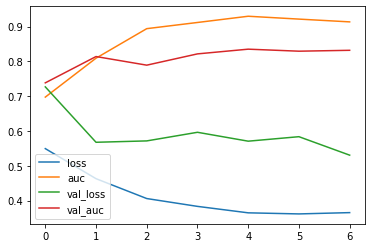

In [34]:
metrics.plot()

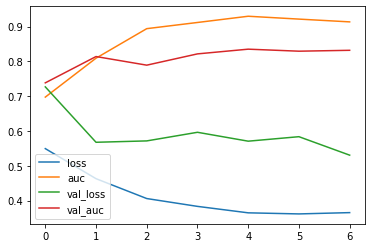

In [35]:
metrics.plot()

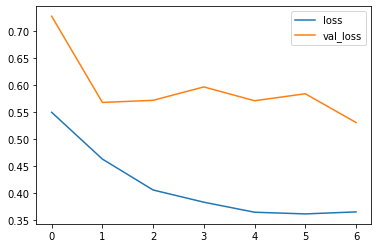

In [36]:
metrics[['loss', 'val_loss']].plot()

<p>We see that the model is overfitting significantly.</p>

In [37]:
model.save('image_classifier_accuracy.h5')

NotImplementedError: Layers with arguments in `__init__` must override `get_config`.